In [13]:
import pandas as pd
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
from processor.processor import Processor as p
from database.adatabase import ADatabase
from backtester.backtester import Backtester
from indicator.indicator import Indicator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
chung = ADatabase("chung")
market = ADatabase("market")

In [3]:
market.connect()
currencies = market.retrieve("currencies")
stocks = market.retrieve("index")
market.disconnect()
crypto = False

In [4]:
if crypto == True:
    index = currencies.copy().rename(columns={"product_id":"ticker"})
    index["name"] = index["ticker"]
    index["base"] = [x.split("-")[1] for x in index["ticker"]]
    index = index[index["base"]=="USD"]
    market.connect()
    spy = market.query("crypto",{"ticker":"BTC-USD"}).rename(columns={"close":"adjclose"})[["start","adjclose","high","low","volume"]]
    spy["date"] = pd.to_datetime(spy["start"].astype(float),unit="s")
    spy["spy"] = spy["adjclose"].astype(float)
    spy["high"] = spy["high"].astype(float)
    spy["low"] = spy["low"].astype(float)
    spy["volume"] = spy["volume"].astype(float)
    market.disconnect()
else:
    index = stocks.copy()
    market.connect()
    spy = p.column_date_processing(market.query("prices",{"ticker":"JPM"}))
    spy["benchmark"] = spy["adjclose"]
    market.disconnect()

In [25]:
chung.connect()
trades = chung.retrieve("spec_adaptive_trades").sort_values("date")
chung.disconnect()
trades = p.column_date_processing(trades)
trades = p.additional_date_cols(trades)
# chung.cloud_connect()
# trades = chung.retrieve("trades").sort_values("date")
# chung.disconnect()
# trades = p.column_date_processing(trades)
# trades = p.additional_date_cols(trades)

In [26]:
trades

,ticker,date,adjclose,sell_price,market_cap,adr,sma,ema,bollinger_upper,bollinger_lower,...,obv,vwap,rogan,y,market_cap_rank,direction,return,year,month,week
23,OPRX,2008-01-11 00:00:00+00:00,0.0070,0.0060,1.033512e+04,0.299527,9.177143,12.433239,25.029176,-6.674890,...,-9114613.0,0.085420,-9.108544e+05,0.857143,0.961671,1,0.857143,2008,1,2
45,UUU,2008-01-11 00:00:00+00:00,6.9300,6.9000,2.121790e+05,0.058516,2.366065,2.224450,4.185038,0.547091,...,246591.0,20.144138,2.477758e+04,0.995671,0.814251,1,0.995671,2008,1,2
36,CHCI,2008-01-11 00:00:00+00:00,5.4600,5.1100,1.081292e+06,0.015875,2.228258,2.146904,4.004411,0.452105,...,-9082466.0,77.530127,-9.079974e+05,0.935897,0.707125,1,0.935897,2008,1,2
94,XELB,2008-01-18 00:00:00+00:00,0.0300,0.0300,2.261590e+02,0.014944,2.786667,2.449469,4.699515,0.873818,...,-446842.0,0.665916,-4.467183e+04,1.000000,0.997053,1,1.000000,2008,1,3
95,OPRX,2008-01-18 00:00:00+00:00,0.0060,0.0060,8.537476e+03,0.288592,9.016667,13.223238,24.155864,-6.122530,...,-9127929.0,0.085291,-9.127796e+05,1.000000,0.965128,1,1.000000,2008,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034,SCPX,2025-03-21 00:00:00+00:00,0.1570,0.1660,7.769173e+05,0.149512,2.726126,15.825459,5.590284,-0.138032,...,65361718.0,3.957048,6.539798e+06,1.057325,0.768745,1,1.057325,2025,3,12
6050,WTO,2025-03-21 00:00:00+00:00,0.2075,0.2369,2.685834e+05,0.105699,1.678364,9.524033,2.357327,0.999402,...,-159086488.0,17.862437,-1.590687e+07,1.141687,0.878158,1,1.141687,2025,3,12
5978,RTC,2025-03-21 00:00:00+00:00,0.3408,0.3150,7.410841e+05,0.150468,14.245629,10.726007,37.835074,-9.343817,...,14344363.0,3.145016,1.444924e+06,0.924296,0.773635,1,0.924296,2025,3,12
6005,ASBP,2025-03-21 00:00:00+00:00,0.6369,0.6304,2.304821e+05,0.083173,15.801768,13.797746,28.262147,3.341388,...,-9335577.0,6.455306,-9.281857e+05,0.989794,0.893032,1,0.989794,2025,3,12


In [27]:
portfolio = Backtester.create_portfolio(trades,spy)

In [28]:
metrics = Backtester.performance(trades,portfolio)

In [29]:
m = pd.DataFrame([metrics])

In [30]:
m[['pnl',
 'downside',
 'coev',
 'std',
 'average_gain',
 'average_loss',
 'w/l',
 'weekly_return',
 'outperformance_ratio']]

,pnl,downside,coev,std,average_gain,average_loss,w/l,weekly_return,outperformance_ratio
0,2.237134e+13,0.353727,0.158057,9.642805e+12,1.122073,0.901272,0.604253,1.034691,2.320003


In [31]:
trades = trades.merge(index[["ticker","name"]],on="ticker",how="left")
trades["count"] = 1

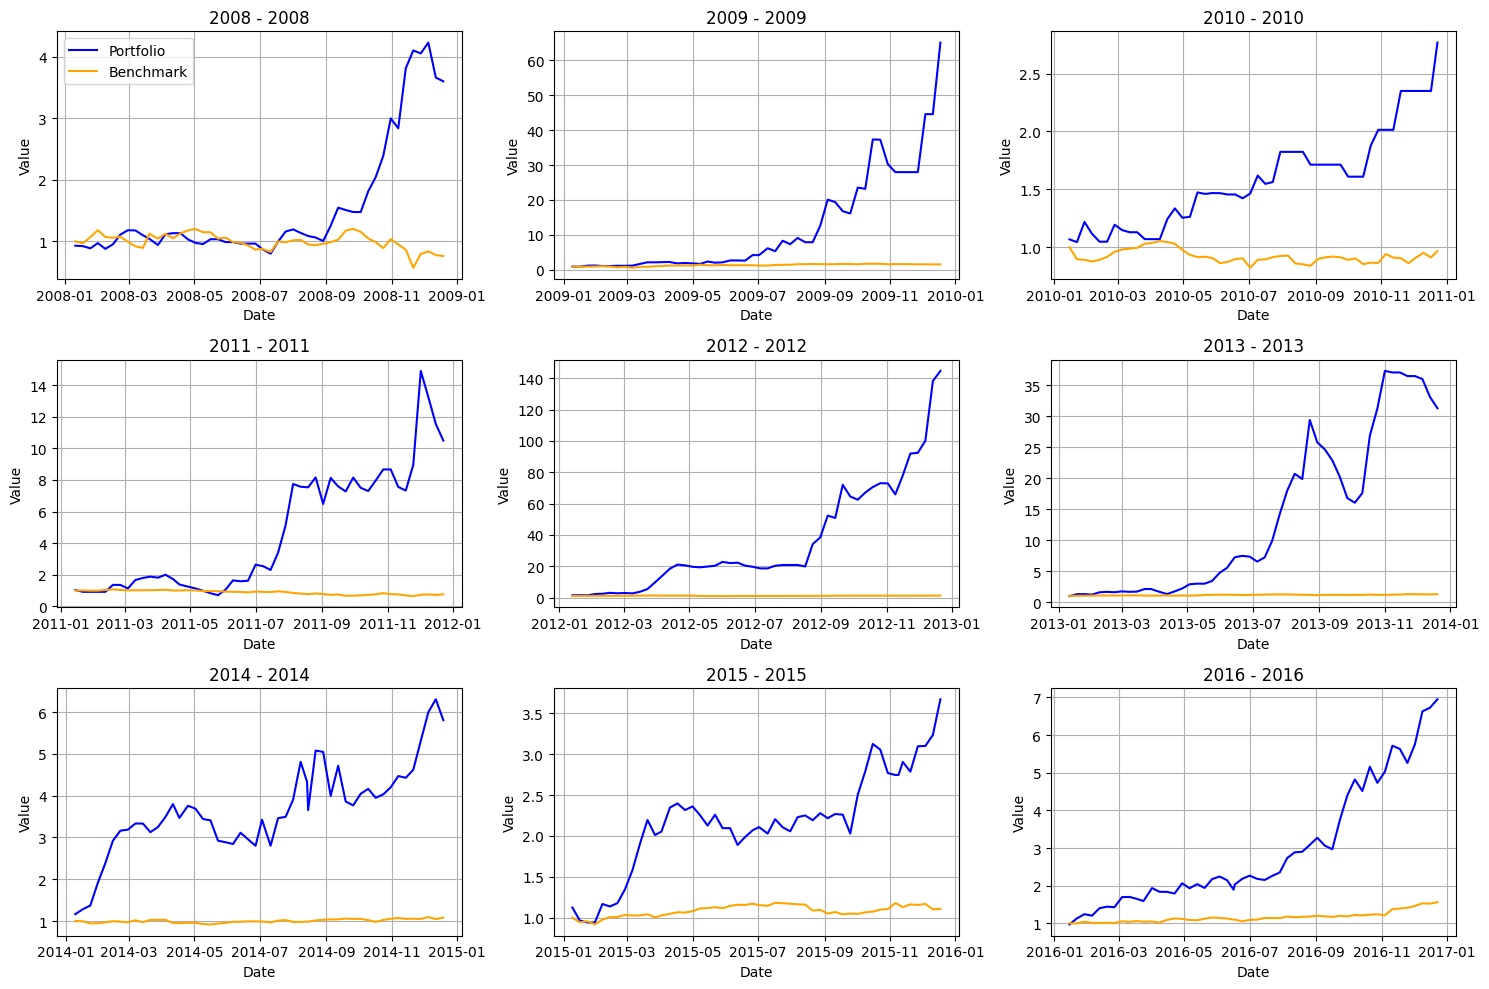

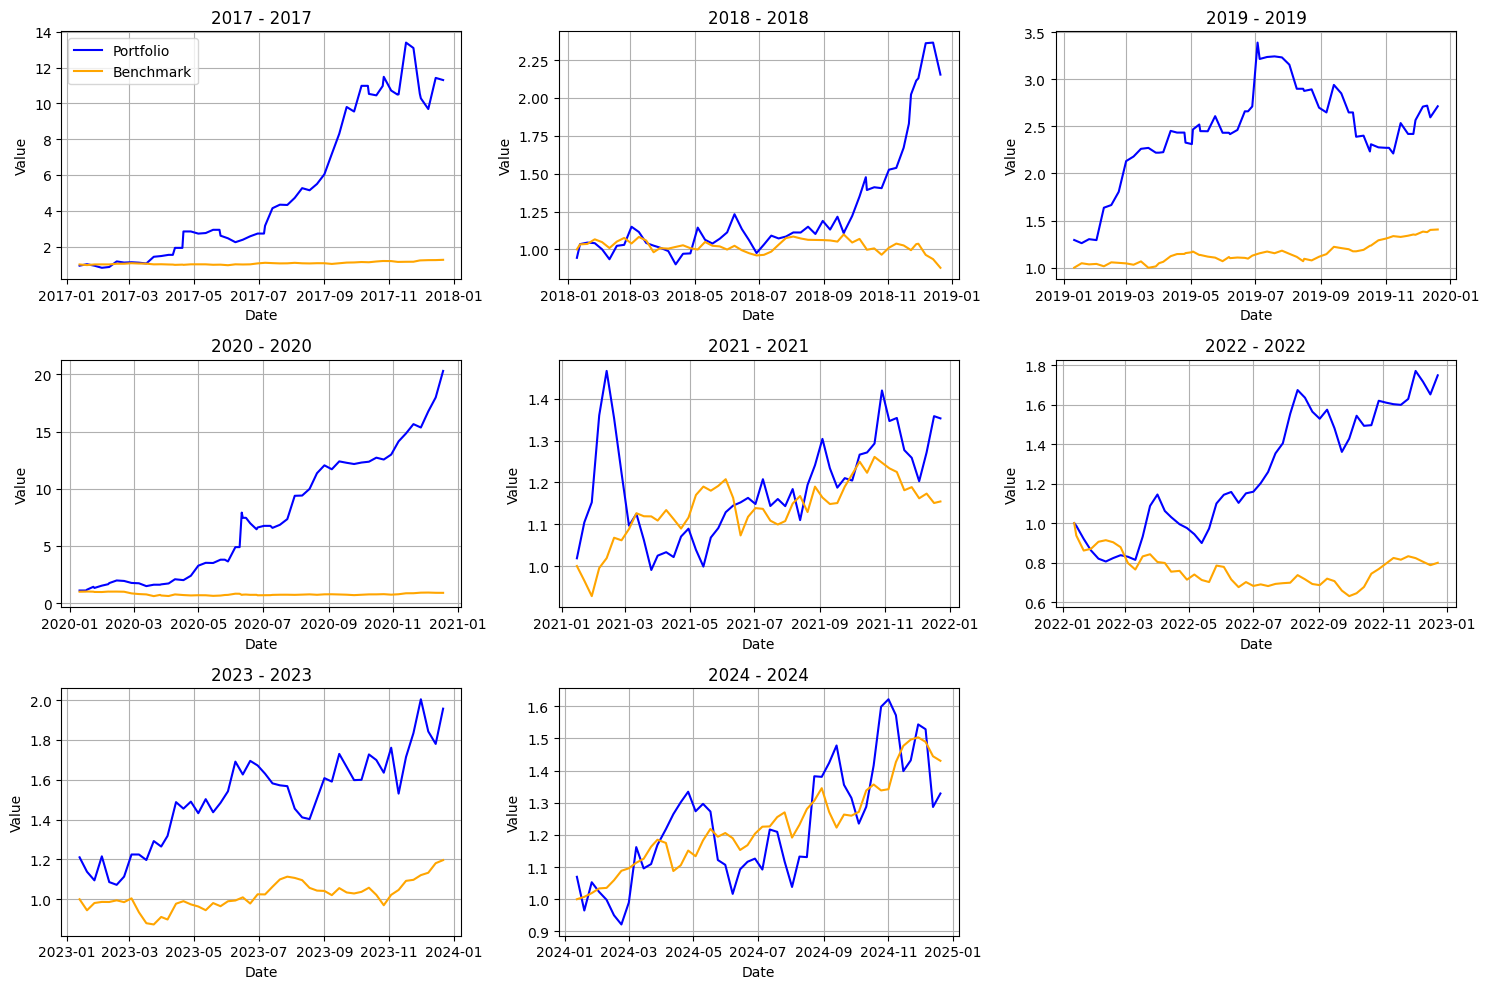

In [32]:
start_year = portfolio["date"].dt.year.min()
end_year = portfolio["date"].dt.year.max()

# Generate 7-year intervals (correcting to 7 years instead of 4)
intervals = list(range(start_year, end_year + 1, 1))

# Setup subplot grid parameters
n_rows, n_cols = 3, 3
plots_per_fig = n_rows * n_cols
num_cycles = len(intervals) - 1

for fig_idx in range(0, num_cycles, plots_per_fig):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten to 1D for easy indexing
    
    for subplot_idx in range(plots_per_fig):
        cycle_idx = fig_idx + subplot_idx
        if cycle_idx >= num_cycles:
            axes[subplot_idx].axis('off')  # Turn off unused subplots
            continue

        start = pd.Timestamp(f"{intervals[cycle_idx]}-01-01",tzinfo=timezone.utc)
        end = pd.Timestamp(f"{intervals[cycle_idx + 1]}-01-01",tzinfo=timezone.utc)
        
        cycle_data = portfolio[(portfolio["date"] >= start) & (portfolio["date"] < end)].copy()
        cycle_data["pv"] = cycle_data["return"].cumprod()
        cycle_data["benchmark_pnl"] = cycle_data["benchmark"] / cycle_data["benchmark"].iloc[0]
        if not cycle_data.empty:
            ax = axes[subplot_idx]
            ax.plot(cycle_data["date"], cycle_data["pv"], label="Portfolio", color='blue')
            ax.plot(cycle_data["date"], cycle_data["benchmark_pnl"], label="Benchmark", color='orange')
            ax.set_title(f"{start.year} - {end.year - 1}")
            ax.set_xlabel("Date")
            ax.set_ylabel("Value")
            ax.grid(True)
        else:
            axes[subplot_idx].axis('off')
    
    # Only add legend to first subplot
    axes[0].legend()
    plt.tight_layout()
    plt.show()

In [43]:
trades[trades["date"]>datetime(2021,1,1,tzinfo=timezone.utc)][["date","name","ticker","adjclose","sell_price","return"]].sort_values("return",ascending=False).iloc[[0,1,2,3,4,5,-5,-4,-3,-2,-1]]

,date,name,ticker,adjclose,sell_price,return
4333,2021-01-29 00:00:00+00:00,Synergy CHC Corp. Common Stock,SNYR,0.4046,0.6188,1.529412
4347,2021-02-05 00:00:00+00:00,Lexaria Bioscience Corp. Common Stock,LEXX,4.7500,7.2000,1.515789
4346,2021-02-05 00:00:00+00:00,"Splash Beverage Group, Inc.",SBEV,4.4700,6.3000,1.409396
4339,2021-01-29 00:00:00+00:00,Synergy CHC Corp. Common Stock,SNYR,0.4046,0.6188,1.409396
4344,2021-02-05 00:00:00+00:00,"Splash Beverage Group, Inc.",SBEV,4.4700,6.3000,1.409396
4345,2021-02-05 00:00:00+00:00,Lexaria Bioscience Corp. Common Stock,LEXX,4.7500,7.2000,1.409396
6122,2025-02-28 00:00:00+00:00,Baijiayun Group Ltd. Class A Ordinary Shares,RTC,0.6200,0.4200,0.711137
6089,2025-01-24 00:00:00+00:00,Connexa Sports Technologies Inc. Common Stock,YYAI,0.7700,0.4480,0.711137
6072,2025-01-10 00:00:00+00:00,"Alpha Modus Holdings, Inc. Class A Common Stock",AMOD,2.6999,1.9200,0.711137
6101,2025-02-07 00:00:00+00:00,Stardust Power Inc. Common Stock,SDST,1.0300,0.6860,0.711137


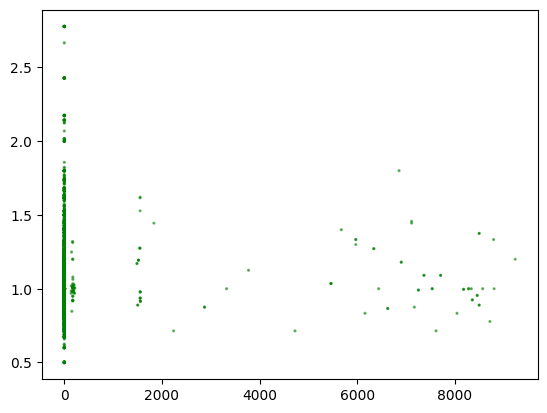

In [34]:
view = trades.copy()
plt.scatter(view["coev"],view["return"],s=view["market_cap_rank"]*2,color=["green" if x == 1 else "red" for x in view["direction"]],alpha=0.5)
plt.show()

In [35]:
signals = Indicator.get_trading_signals()
trades[signals + ["return"]].corr()[["return"]].sort_values("return")

,return
atr,-0.050708
adr,-0.037444
obv,-0.028811
rogan,-0.027919
market_impact,-0.027677
bollinger_lower,-0.018373
vwap,-0.009381
sma,-0.006891
williams_r,-0.003583
roc,-0.002380


In [36]:
ticker_analysis = trades.groupby(["name","ticker"]).agg({"return":"mean","coev":"mean","count":"sum","adjclose":"mean","market_cap":"mean"}).sort_values("count",ascending=False)
ticker_analysis["cum_return"] = ticker_analysis["return"] ** ticker_analysis["count"]
ticker_analysis.sort_values("cum_return",ascending=False).tail(20)

,,return,coev,count,adjclose,market_cap,cum_return
name,ticker,,,,,,
Aspira Women's Health Inc. Common Stock,AWH,0.967307,0.875863,21,1.242071,5.671997e+04,0.497561
Patrick Industries Inc,PATK,0.869671,0.633614,5,0.190539,6.205511e+03,0.497480
Hudson Technologies Inc,HDSN,0.886093,0.406768,6,0.607150,7.481294e+05,0.484033
"Voyager Therapeutics, Inc. Common Stock",VYGR,0.945117,0.186670,13,5.983077,3.339860e+06,0.480076
374Water Inc. Common Stock,SCWO,0.974743,0.481685,29,0.223621,1.295613e+03,0.476221
"Spero Therapeutics, Inc. Common Stock",SPRO,0.958038,0.711529,18,1.034056,1.586464e+06,0.462262
P3 Health Partners Inc. Common Stock,PIII,0.941790,0.455099,13,1.197046,4.050967e+05,0.458570
Aptorum Group Limited Class A Ordinary Shares,APM,0.973234,0.616947,29,33.580000,1.411142e+06,0.455300
"Vivani Medical, Inc. Common Stock (DE)",VANI,0.969954,0.526224,26,3.006523,1.539027e+06,0.452410


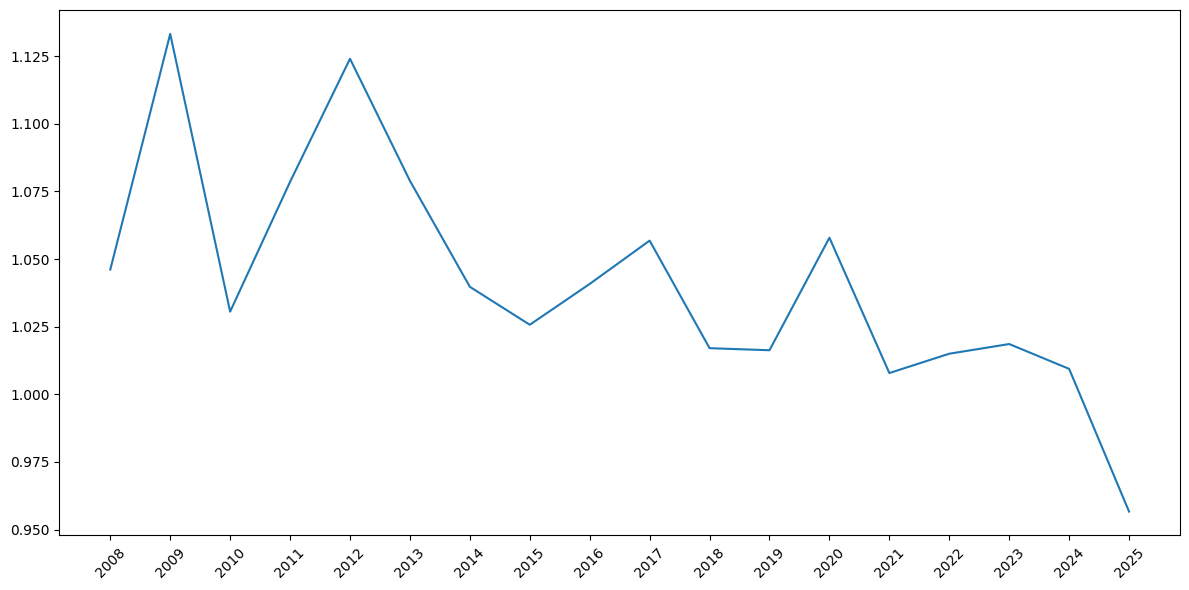

In [37]:
timeframe = "year"
timeframe_analysis = trades.groupby([timeframe]).agg({"return":"mean","coev":"mean","count":"sum","adjclose":"mean","market_cap":"mean"}).sort_values(timeframe).reset_index()
plt.figure(figsize=(12, 6))  # Optional: wider figure
plt.plot(timeframe_analysis[timeframe], timeframe_analysis["return"])

# Set x-ticks to show every week
plt.xticks(timeframe_analysis[timeframe], rotation=45)  # Rotate for readability

plt.tight_layout()  # Prevent label cutoff
plt.show()

In [38]:
portfolio["diff"] = portfolio["pnl"].pct_change()
portfolio.sort_values("diff",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,diff
211,2012-03-30 00:00:00+00:00,1.782609,6.566621e+04,32.153643,1.214386,0.782609
232,2012-08-24 00:00:00+00:00,1.719462,2.316096e+05,26.383293,0.996450,0.719462
196,2011-12-02 00:00:00+00:00,1.663586,9.645301e+03,22.447679,0.847809,0.663586
174,2011-07-01 00:00:00+00:00,1.626190,1.707156e+03,28.633665,1.081443,0.626190
658,2020-06-11 00:00:00+00:00,1.615854,2.379284e+12,85.121539,3.214890,0.615854
203,2012-02-03 00:00:00+00:00,1.610098,1.505989e+04,26.769062,1.011020,0.610098
90,2009-10-16 00:00:00+00:00,1.608466,1.342596e+02,31.170191,1.177243,0.608466
97,2009-12-04 00:00:00+00:00,1.592593,1.603094e+02,28.246717,1.066829,0.592593
83,2009-08-28 00:00:00+00:00,1.592593,4.542520e+01,29.010607,1.095679,0.592593
74,2009-06-26 00:00:00+00:00,1.592593,1.527220e+01,23.251115,0.878153,0.592593


In [39]:
trades[["date","name","ticker","adjclose","sell_price","return"]].sort_values("return",ascending=False).iloc[[0,1,2,3,4,5,-5,-4,-3,-2,-1]]

,date,name,ticker,adjclose,sell_price,return
319,2009-12-04 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,1.345698,11.124441,2.777778
245,2009-07-10 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,0.897132,11.124441,2.777778
237,2009-06-26 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,0.457537,11.124441,2.777778
238,2009-06-26 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,0.457537,11.124441,2.777778
267,2009-08-28 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,1.525125,11.124441,2.777778
284,2009-10-02 00:00:00+00:00,OptimizeRx Corporation Common Stock,OPRX,0.450000,1.250000,2.777778
557,2011-05-27 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,11.124441,2.063404,0.500000
556,2011-05-27 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,11.124441,2.063404,0.500000
549,2011-05-13 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,11.124441,2.018548,0.500000
548,2011-05-13 00:00:00+00:00,ACCESS Newswire Inc.,ACCS,11.124441,2.018548,0.500000


In [40]:
trades[["date","name","ticker","adjclose","sell_price","return"]].sort_values("date",ascending=True).tail(50)

,date,name,ticker,adjclose,sell_price,return
6095,2025-01-31 00:00:00+00:00,Femto Technologies Inc. Common Stock,FMTO,4.2000,3.500100,0.833357
6104,2025-02-07 00:00:00+00:00,"Scorpius Holdings, Inc.",SCPX,0.2452,0.223000,0.909462
6103,2025-02-07 00:00:00+00:00,Connexa Sports Technologies Inc. Common Stock,YYAI,0.4000,0.412000,1.030000
6102,2025-02-07 00:00:00+00:00,Femto Technologies Inc. Common Stock,FMTO,3.6000,3.320000,0.922222
6105,2025-02-07 00:00:00+00:00,Powell Max Limited Class A Ordinary Shares,PMAX,0.3652,0.440900,1.207284
6100,2025-02-07 00:00:00+00:00,Baijiayun Group Ltd. Class A Ordinary Shares,RTC,0.7550,0.728000,0.964238
6099,2025-02-07 00:00:00+00:00,"Volcon, Inc. Common stock",VLCN,3.3400,1.500000,0.711137
6101,2025-02-07 00:00:00+00:00,Stardust Power Inc. Common Stock,SDST,1.0300,0.686000,0.711137
6106,2025-02-14 00:00:00+00:00,UTime Limited Ordinary Shares,WTO,0.2652,0.279900,1.055430
6107,2025-02-14 00:00:00+00:00,"Scorpius Holdings, Inc.",SCPX,0.2164,0.270000,1.247689


In [41]:
trades.groupby(["name","ticker"]).agg({"return":"mean","coev":"mean","count":"sum","adjclose":"mean","market_cap":"mean"}).sort_values("count",ascending=False).head(20)

,,return,coev,count,adjclose,market_cap
name,ticker,,,,,
ACCESS Newswire Inc.,ACCS,1.202273,0.662906,146,3.861208,55620.303394
"Giftify, Inc. Common Stock",GIFT,1.100150,0.587880,127,1.409336,201492.007445
"Nixxy, Inc. Common Stock",NIXX,1.044179,1.136699,118,121.785038,283183.125395
"Golden Matrix Group, Inc. Common Stock",GMGI,1.064105,3575.581823,115,2.557930,944326.318602
Bitfarms Ltd. Common Stock,BITF,1.031404,0.712864,110,0.443309,2284.531995
AppTech Payments Corp. Common Stock,APCX,1.105226,0.567025,107,0.234879,10894.962314
"Bit Digital, Inc. Ordinary Shares",BTBT,0.966554,0.627483,86,1.185937,325086.993687
"Skye Bioscience, Inc. Common Stock",SKYE,1.007940,0.420457,80,0.108431,52511.852741
Addentax Group Corp. Common Stock,ATXG,1.004169,1.034483,73,40.454110,25401.179988


In [42]:
trades.groupby(["date"]).agg({"return":"mean","coev":"mean","count":"sum","adjclose":"mean","market_cap":"mean"}).sort_values("return",ascending=False).head(20)

,return,coev,count,adjclose,market_cap
date,,,,,
2009-08-28 00:00:00+00:00,1.888889,0.276579,4,75.775312,41895.461889
2009-12-04 00:00:00+00:00,1.888889,0.918782,4,75.725349,59124.090754
2009-06-26 00:00:00+00:00,1.888889,1.169808,4,0.391519,28008.872139
2011-07-01 00:00:00+00:00,1.826786,0.411345,4,9.129415,219956.641164
2009-07-10 00:00:00+00:00,1.788889,1.667776,4,0.648816,27177.669041
2012-03-30 00:00:00+00:00,1.782609,0.800527,3,0.762333,37976.560250
2011-06-10 00:00:00+00:00,1.776623,0.514704,4,4.494202,120511.350174
2011-12-02 00:00:00+00:00,1.751722,0.660842,8,3.024972,39865.622482
2011-08-05 00:00:00+00:00,1.738947,0.468180,4,0.793587,34281.974443
